In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import xgboost as xgb

# loading dataset

In [2]:
df = pd.read_csv('../input/aeroplane-crash-data-from-1919-to-2025/cleaned_data.csv')

In [3]:
df.head()

,aircraft_type,registration,operator,fatalities,location,damage,Time,Flight #,Route,cn/In,...,crashes,serious_injuries,minor_injuries,incidents,date,year,month,day,hour,fatality_overcount
0,wright flyer iii,unknown,military - u.s. army,1.0,"fort myer, virginia",unknown,17:18,unknown,demonstration,1,...,0.0,0.0,0.0,0.0,1908-09-17,1908,9,17,17,False
1,dirigible,unknown,mililtary - u.s. navy,5.0,"atlanticity, new jersey",unknown,06:30,unknown,test flight,unknown,...,0.0,0.0,0.0,0.0,1912-07-12,1912,7,12,6,False
2,curtiss seaplane,unknown,private,1.0,"victoria, british columbia, canada",unknown,Unknown,-,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-08-06,1913,8,6,-1,False
3,zeppelin l-1 (airship),unknown,military - german navy,14.0,over the north sea,unknown,18:30,unknown,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-09-09,1913,9,9,18,False
4,zeppelin l-2 (airship),unknown,military - german navy,30.0,"near johannisthal, germany",unknown,10:30,unknown,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-10-17,1913,10,17,10,False


In [4]:
df.isnull().sum()

aircraft_type         0
registration          0
operator              0
fatalities            0
location              0
damage                0
Time                  0
Flight #              0
Route                 0
cn/In                 0
Aboard                0
Ground                0
Summary               0
summary               0
crashes               0
serious_injuries      0
minor_injuries        0
incidents             0
date                  0
year                  0
month                 0
day                   0
hour                  0
fatality_overcount    0
dtype: int64

In [5]:
df.shape

(30968, 24)

In [6]:
df.fatality_overcount.value_counts()

fatality_overcount
False    22055
True      8913
Name: count, dtype: int64

# data preprocessing

In [7]:
# renaming columns
df.rename(columns={'Summary': 'summ1', 'summary': 'summ2'}, inplace=True)
df.rename(columns={'flight #': 'flight_num'}, inplace=True)

In [8]:
# converting columns to lowercase
df.columns = df.columns.str.lower()

In [9]:
# converting data type from float to int
df.aboard = df.aboard.astype(int)
df.fatalities = df.fatalities.astype(int)
df.crashes = df.crashes.astype(int)
df.serious_injuries = df.serious_injuries.astype(int)
df.minor_injuries = df.minor_injuries.astype(int)
df.incidents = df.incidents.astype(int)

In [10]:
# taking last 2 decade data
df = df[(df['year'] >= 2005) & (df['year'] <= 2025)]

In [11]:
# reset index to date (datetime)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.head(2)

,aircraft_type,registration,operator,fatalities,location,damage,time,flight #,route,cn/in,...,summ2,crashes,serious_injuries,minor_injuries,incidents,year,month,day,hour,fatality_overcount
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,cessna 551 citation ii/sp,n35403,jet services,0,"ainsworth airport, ne (anw)",w/o,Unknown,unknown,unknown,unknown,...,No summary available,0,0,0,0,2005,1,1,-1,False
2005-01-01,unknown,unknown,unknown,1689,unknown,unknown,Unknown,unknown,unknown,unknown,...,No summary available,2031,426,620,0,2005,1,1,-1,True


In [12]:
# df[df.summ1 == 'No summary available'].value_counts().sum() # 4878 valid

# df[df.summ2 == 'No summary available'].value_counts().sum() # 31 valid

# df[(df.summ2 == 'No summary available') & (df.summ1 == 'No summary available')].value_counts().sum() # 26059

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5469 entries, 2005-01-01 to 2025-11-14
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   aircraft_type       5469 non-null   object 
 1   registration        5469 non-null   object 
 2   operator            5469 non-null   object 
 3   fatalities          5469 non-null   int64  
 4   location            5469 non-null   object 
 5   damage              5469 non-null   object 
 6   time                5469 non-null   object 
 7   flight #            5469 non-null   object 
 8   route               5469 non-null   object 
 9   cn/in               5469 non-null   object 
 10  aboard              5469 non-null   int64  
 11  ground              5469 non-null   float64
 12  summ1               5469 non-null   object 
 13  summ2               5469 non-null   object 
 14  crashes             5469 non-null   int64  
 15  serious_injuries    5469 non-null   i

In [14]:
# number of unique aircraft type
len(df['aircraft_type'].unique())

1533

In [15]:
df[df['crashes']==0].value_counts().sum()

5454

In [16]:
# df['year'].value_counts() # unsorted
# df['year'].value_counts().sort_index() # sorted index : HERE index = year

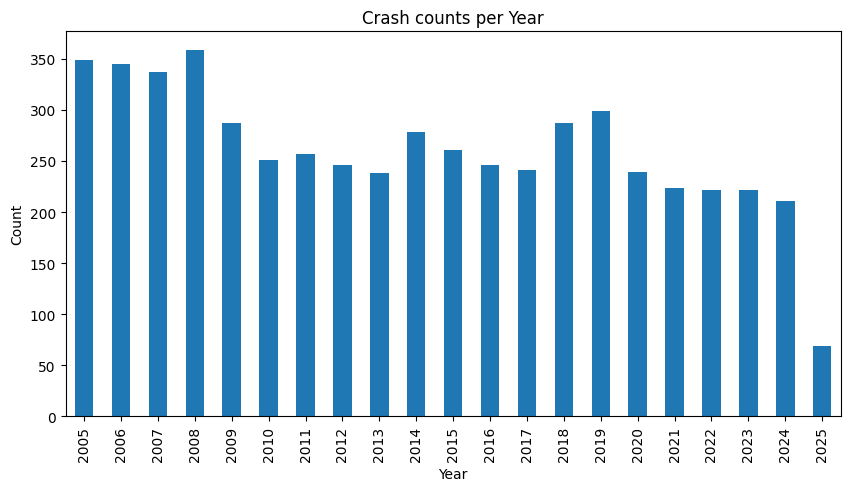

In [17]:
plt.figure(figsize=(10,5))
df['year'].value_counts().sort_index().plot(rot=90, kind='bar') # or df.groupby('year').size().plot(kind='bar', rot=90)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Crash counts per Year')
plt.show()

In [18]:
df.head(1)

,aircraft_type,registration,operator,fatalities,location,damage,time,flight #,route,cn/in,...,summ2,crashes,serious_injuries,minor_injuries,incidents,year,month,day,hour,fatality_overcount
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,cessna 551 citation ii/sp,n35403,jet services,0,"ainsworth airport, ne (anw)",w/o,Unknown,unknown,unknown,unknown,...,No summary available,0,0,0,0,2005,1,1,-1,False


In [19]:
df.columns

Index(['aircraft_type', 'registration', 'operator', 'fatalities', 'location',
       'damage', 'time', 'flight #', 'route', 'cn/in', 'aboard', 'ground',
       'summ1', 'summ2', 'crashes', 'serious_injuries', 'minor_injuries',
       'incidents', 'year', 'month', 'day', 'hour', 'fatality_overcount'],
      dtype='object')

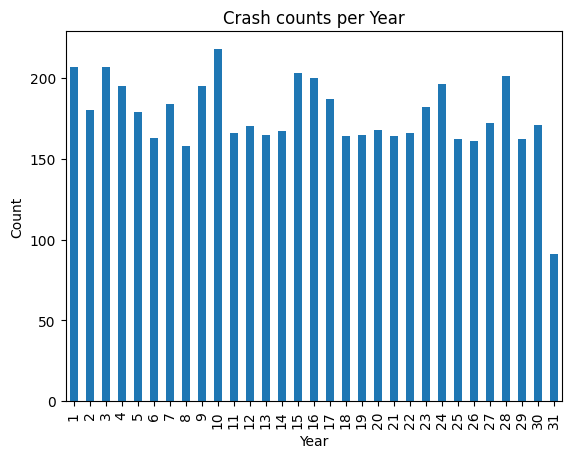

In [20]:
# plt.figure(figsize=(10,5))
df['day'].value_counts().sort_index().plot(rot=90, kind='bar') 
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Crash counts per Year')
plt.show()

<Axes: xlabel='day'>

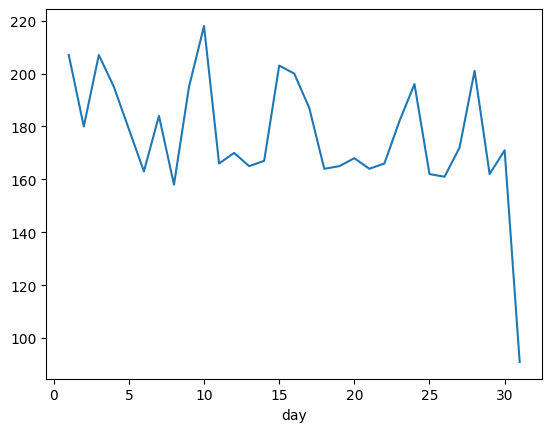

In [21]:
df['day'].value_counts().sort_index().plot()

In [22]:
# df.plot()